# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# when running in Udacity workspace
# !pip -q install ./python

import time
import torch
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
## when running locally
env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [13]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [9]:
def maddpg(n_episodes=3000, train_mode=True,_solved_score = 0.5 ,_consec_episodes = 100, _print_every = 10, _add_noise = True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        train_mode (bool)     : if 'True' set environment to training mode
        _solved_score (float)  : min avg score over consecutive episodes
        _consec_episodes (int) : number of consecutive episodes used to calculate score
        _print_every (int)     : interval to display results
        _add_noise (bool)     : if 'True' add noise in the training process

    """
    scores_final = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False 
    scores_window = deque(maxlen=_consec_episodes)

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.noise.reset()
        agent_1.noise.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = np.concatenate((agent_0.act(states, _add_noise), agent_1.act(states, _add_noise)), axis=0).flatten()           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        episode_best_score = np.max(scores)
        scores_window.append(episode_best_score)
        scores_final.append(episode_best_score)
        moving_average.append(np.mean(scores_window))

        # save best score                        
        if episode_best_score > best_score:
            best_score = episode_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % _print_every == 0:
            print('Episode number {} \tWithin \t{} episodes\tMean score: {:5.2f} (H: {:5.2f} / L: {:5.2f}) \tMoving Average: {:.3f}'.format(
                i_episode, _print_every, np.mean(scores_final[-_print_every:]), np.max(scores_final[-_print_every:]), np.min(scores_final[-_print_every:]), moving_average[-1]))

        # determine if environment is solved and save the best performing models
        if moving_average[-1] >= _solved_score:
            print('<-- Environment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                    i_episode-_consec_episodes, moving_average[-1], _consec_episodes))
            # save weights
            torch.save(agent_0.actor_local.state_dict(), 'models/checkpoint_actor_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'models/checkpoint_actor_1.pth')
            break
            
    return scores_final, moving_average

### Best Model

In [10]:
# initialize agents
from maddpg_agent import Agent
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

# run the training loop
scores, avgs = maddpg()

/Users/tancao/Desktop/p3_collab-compet/maddpg_agent.py:123: UserWarning: Using a target size (torch.Size([128, 2])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(Q_expected, Q_targets)


Episode number 10 	Within 	10 episodes	Mean score:  0.00 (H:  0.00 / L:  0.00) 	Moving Average: 0.000
Episode number 20 	Within 	10 episodes	Mean score:  0.00 (H:  0.00 / L:  0.00) 	Moving Average: 0.000
Episode number 30 	Within 	10 episodes	Mean score:  0.00 (H:  0.00 / L:  0.00) 	Moving Average: 0.000
Episode number 40 	Within 	10 episodes	Mean score:  0.00 (H:  0.00 / L:  0.00) 	Moving Average: 0.000
Episode number 50 	Within 	10 episodes	Mean score:  0.00 (H:  0.00 / L:  0.00) 	Moving Average: 0.000
Episode number 60 	Within 	10 episodes	Mean score:  0.00 (H:  0.00 / L:  0.00) 	Moving Average: 0.000
Episode number 70 	Within 	10 episodes	Mean score:  0.05 (H:  0.10 / L:  0.00) 	Moving Average: 0.007
Episode number 80 	Within 	10 episodes	Mean score:  0.05 (H:  0.10 / L:  0.00) 	Moving Average: 0.013
Episode number 90 	Within 	10 episodes	Mean score:  0.02 (H:  0.10 / L:  0.00) 	Moving Average: 0.013
Episode number 100 	Within 	10 episodes	Mean score:  0.02 (H:  0.10 / L:  0.00) 	M

Episode number 810 	Within 	10 episodes	Mean score:  0.29 (H:  1.10 / L:  0.10) 	Moving Average: 0.257
Episode number 820 	Within 	10 episodes	Mean score:  0.59 (H:  2.30 / L:  0.10) 	Moving Average: 0.281
Episode number 830 	Within 	10 episodes	Mean score:  0.45 (H:  1.70 / L:  0.10) 	Moving Average: 0.305
Episode number 840 	Within 	10 episodes	Mean score:  0.77 (H:  2.30 / L:  0.00) 	Moving Average: 0.356
Episode number 850 	Within 	10 episodes	Mean score:  0.26 (H:  0.60 / L:  0.10) 	Moving Average: 0.360
Episode number 860 	Within 	10 episodes	Mean score:  0.98 (H:  3.40 / L:  0.10) 	Moving Average: 0.436
<-- Environment solved in 769 episodes!                 
<-- Moving Average: 0.503 over past 100 episodes


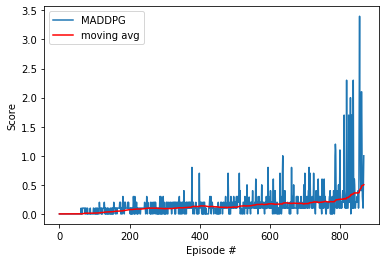

In [11]:
# plot the scores

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc = 0)
plt.show()

---
### 5. Watch the trained agent performing in the environment

In [5]:
_add_noise = False
## reinitialize the agents (if needed)
from maddpg_agent import Agent
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)

# load the weights from file
agent_0_weights = 'models/checkpoint_actor_0.pth'
agent_1_weights = 'models/checkpoint_actor_1.pth'
agent_0.actor_local.load_state_dict(torch.load(agent_0_weights))
agent_1.actor_local.load_state_dict(torch.load(agent_1_weights))     

<All keys matched successfully>

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = np.reshape(env_info.vector_observations, (1,48))  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.concatenate((agent_0.act(states, _add_noise), agent_1.act(states, _add_noise)), axis=0).flatten() # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = np.reshape(env_info.vector_observations, (1, 48)) # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += np.max(rewards)                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.9000000134110451
Score (max over agents) from episode 2: 1.3000000193715096
Score (max over agents) from episode 3: 0.800000011920929
Score (max over agents) from episode 4: 0.5000000074505806
Score (max over agents) from episode 5: 1.2000000178813934


When finished, you can close the environment.

In [21]:
env.close()